In [32]:
import torch
import torch.nn as nn
from torch.optim import SGD #Stochastic gradient descent
import torch.nn.functional as F #for one hot encoding
from torch.utils.data import Dataset, DataLoader
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms,datasets
from torchvision.transforms import ToTensor


In [33]:
dataset = datasets.MNIST(root = './data', train = True, download = True, transform = ToTensor())
dataset_loader = DataLoader(dataset , batch_size = len(dataset), shuffle = False)

'''
here the data is split batch wise as training and testing
#Loading dataset

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5)
]
)
#loading dataset
train_dataset = datasets.MNIST(root='./data',train = True, transform = transform, download = True )
test_dataset = datasets.MNIST (root= './data', train= False, transform = transform, download= True)

#Dataloader
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)#shuffle - Shuffles dataset during each epoch
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False)
'''

"\nhere the data is split batch wise as training and testing\n#Loading dataset\n\ntransform = transforms.Compose([\n    transforms.ToTensor(),\n    transforms.Normalize(0.5,0.5)\n]\n)\n#loading dataset\ntrain_dataset = datasets.MNIST(root='./data',train = True, transform = transform, download = True )\ntest_dataset = datasets.MNIST (root= './data', train= False, transform = transform, download= True)\n\n#Dataloader\ntrain_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)#shuffle - Shuffles dataset during each epoch\ntest_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False)\n"

torch.Size([60000, 1, 28, 28])
torch.Size([60000, 28, 28])


Text(0.5, 1.0, 'Number is 9')

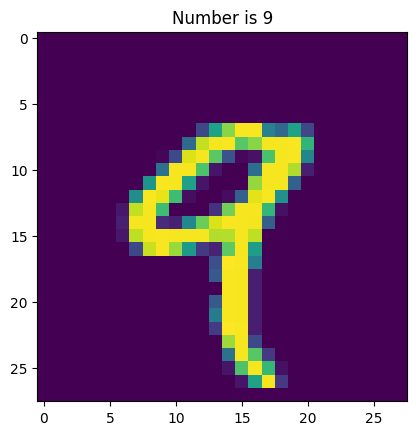

In [34]:
x,y = next(iter(dataset_loader))
print (x.shape)
#plotting the data
print (x.squeeze().shape)
plt.imshow(x[4].squeeze()) #imshow- image show
plt.title(f'Number is {y[4]}')


The tensor passes has 3 dimensions (1,28,28) here 1 is the channel (Grayscale)
to remove this use squeeze from plt

to avoid all these we can simply download the dataset from kaggle

One Hot Encoder

In [35]:
#Example

y_eg= torch.tensor([1,3,4,5,3,2])
F.one_hot(y_eg)

#Gets changed into class
# eg 1 is in class 1, 2 in class 3

tensor([[0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 0]])

In [36]:
print(y)
F.one_hot(y)

tensor([5, 0, 4,  ..., 5, 6, 8])


tensor([[0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 1, 0]])

In [37]:
#convert images to vector
print (x.shape)
x.view(-1,28*28).shape

torch.Size([60000, 1, 28, 28])


torch.Size([60000, 784])

Pytorch dataset object

In [41]:
class CTDataset(Dataset):
  def __init__(self,dataset_loader):
    self.x,self.y = next(iter(dataset_loader))
    self.x = self.x
    '''/255 #normalising all data btw 0 and 1
    self.y = F.one_hot(self.y, num_classes = 10).to(float)'''
  def __len__(self):
    return (self.x.shape[0])
  def __getitem__(self,idx):
    return self.x[idx] , self.y[idx]

In [42]:
#split into training and testing

train = datasets.MNIST(root='./data',train = True, transform = ToTensor(), download = True )
test = datasets.MNIST (root= './data', train= False, transform = ToTensor(), download= True)

train_loader = DataLoader(train, batch_size = len(train), shuffle = False)
test_loader = DataLoader(test, batch_size = len(test), shuffle = False)

train_ds = CTDataset(dataset_loader= train_loader)
test_ds = CTDataset(dataset_loader= test_loader)


In [43]:
len(train_ds)

60000

Pytorch Dataloader object

In [64]:
train_dl = DataLoader(train_ds, batch_size=5)
for x,y in train_dl:
  print (x.shape)
  print (y.shape)
  print (y)
  break

torch.Size([5, 1, 28, 28])
torch.Size([5])
tensor([5, 0, 4, 1, 9])


In [65]:
len(train_dl)

12000

Cross Entropy Loss

In [66]:
L = nn.CrossEntropyLoss()

The network

In [67]:
class NeuralNetwork(nn.Module): #our class is inheriting from nn.Module which contains functionalities of nn
    def __init__(self):
        super().__init__() #inherits innit of nn.Module
        self.Matrix1 = nn.Linear(28**2,100) #Linear layer (indiviual layer) parameters given input and output
        self.Matrix2 = nn.Linear(100,50)
        self.Matrix3 = nn.Linear(50,10)
        self.R = nn.ReLU() #Activation func
    def forward(self,x):
        x = x.view(-1,28**2)
        x = self.R(self.Matrix1(x))
        x = self.R(self.Matrix2(x))
        x = self.Matrix3(x)
        return x

In [68]:
f = NeuralNetwork()

In [69]:
xs,ys  = train_ds[0:4]
xs.shape
nn_xs = f(xs)

In [70]:
L(nn_xs, ys)


tensor(2.2763, grad_fn=<NllLossBackward0>)

**Training**

In [71]:
def training(train_dl,f, no_epochs =20  ):
  # optimizer
  opt = SGD(f.parameters(), lr=0.01)#paramters are passed so that wt and bias can be adjusted
  #lr = how much w and b must be adjusted
  L = nn.CrossEntropyLoss()

  loss_list = []
  epoch_list = []
  for epochs in range (no_epochs):

    for i,(x,y) in enumerate(train_dl):
      opt.zero_grad() #flush gradient each epoch
      loss = L(f(x),y)
      loss.backward()#computes gradient
      opt.step() #adjust param using the gradient calculated before
      #print (f'Epoch no{epochs} - {loss}')
      loss_list.append(loss.item())
      epoch_list.append(epochs+i/len(train_dl))
  return np.array(epoch_list), np.array(loss_list)


In [72]:
epoch_list, loss_list = training(train_dl, f)

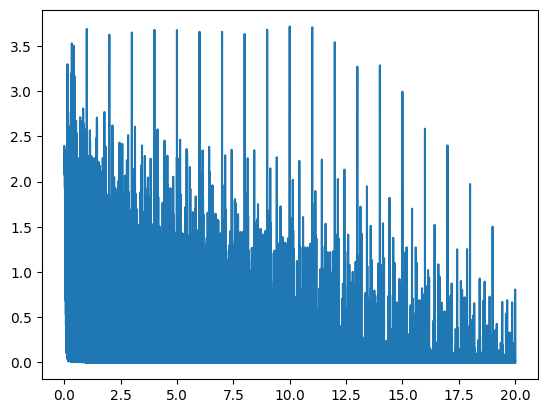

In [73]:
plt.plot(epoch_list,loss_list)

In [84]:
epoch_data_avgd = epoch_list.reshape(20,-1).mean(axis=1)
loss_data_avgd = loss_list.reshape(20,-1).mean(axis=1)

Text(0.5, 1.0, 'Cross Entropy (avgd per epoch)')

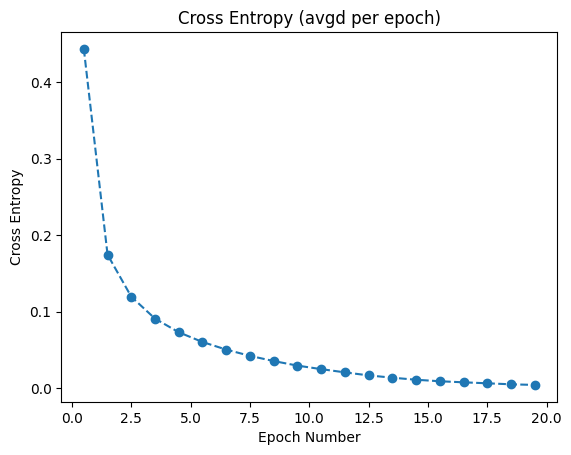

In [87]:
plt.plot(epoch_data_avgd, loss_data_avgd, 'o--')
plt.xlabel('Epoch Number')
plt.ylabel('Cross Entropy')
plt.title('Cross Entropy (avgd per epoch)')


In [91]:

x_sample = train_ds[0][0]
yhat_sample = f(x_sample)
yhat_sample


tensor([[-10.1947,   5.7503,   1.9071,  21.8312, -23.8345,  28.0618, -12.7157,
           0.5885,  -3.5247,   2.9093]], grad_fn=<AddmmBackward0>)

In [92]:
y_sample = train_ds[0][1]
y_sample

tensor(5)

In [93]:
torch.argmax(yhat_sample)


tensor(5)

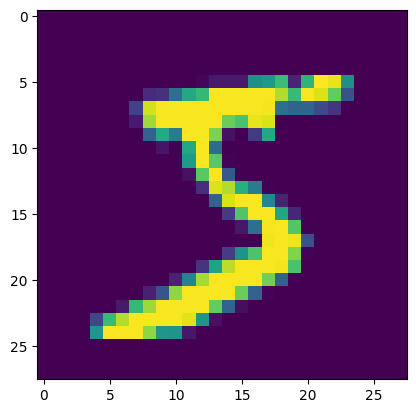

In [94]:

plt.imshow(x_sample.squeeze())

In [97]:
xs, ys = train_ds[0:2000]
yhats = f(xs).argmax(axis=1)

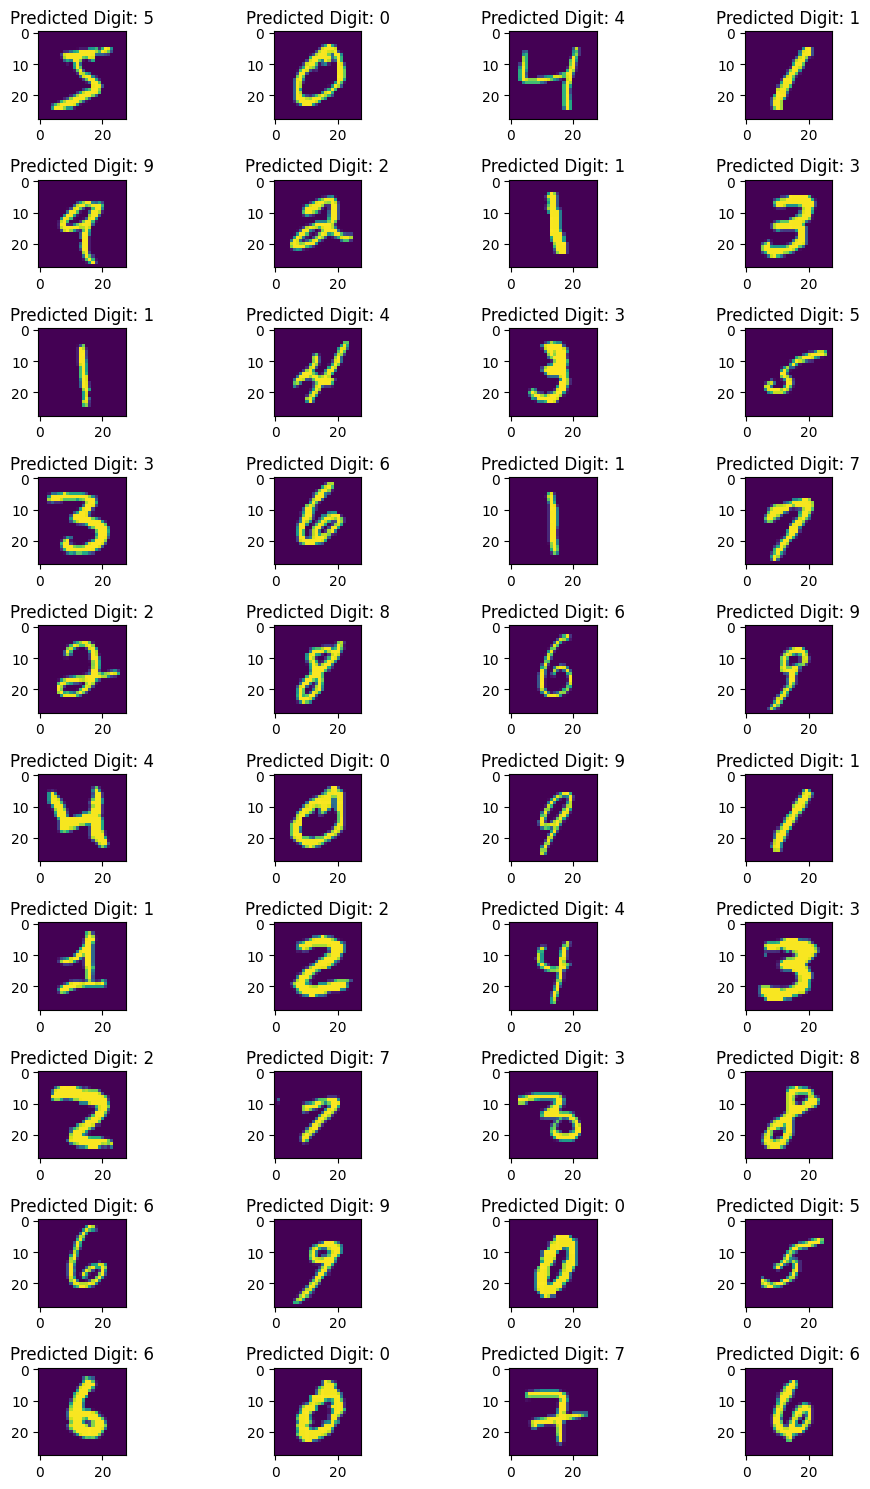

In [100]:
fig, ax = plt.subplots(10,4,figsize=(10,15))
for i in range(40):
    plt.subplot(10,4,i+1)
    plt.imshow(xs[i].squeeze())
    plt.title(f'Predicted Digit: {yhats[i]}')
fig.tight_layout()
plt.show()

In [102]:
test_dl = DataLoader(test_ds)
def calculate_accuracy(model, dataloader):
    model.eval()  # Set model to evaluation mode

    correct = 0
    total = 0

    with torch.no_grad():  # No gradient calculation
        for x, y in dataloader:
            preds = model(x)  # Get predictions
            predicted = preds.argmax(dim=1)  # Get class with highest probability
            correct += (predicted == y).sum().item()  # Count matches
            total += y.size(0)  # Total samples

    return correct / total * 100  # Return accuracy as a percentage
test_accuracy = calculate_accuracy(f, test_dl)
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 97.60%
